In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, Bidirectional, Input
from keras.layers import Attention, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import stanza
from keras.utils import to_categorical
from keras.layers import BatchNormalization, Dropout

*<h3>Load Data<h3>*

In [3]:
# read csv file into pandas
df = pd.read_csv("../datasets/shuffled4.csv")
df.head(10)

,question_id,answer,grade
0,4,في المدينة المنورة، 570 ميلادي: نبض الإسلام، و...,0
1,4,قريش، مكة: نبينا الكريم -صلى الله عليه وسلم-، ...,2
2,4,تاريخ مكة يتلألأ بميلاد المصطفى محمد -صلى الله...,1
3,4,قريش: جذور نبوية، مكة: مهد الإسلام، محمد -صلى ...,2
4,4,جذور قريش وأحضان مكة، شهدتا نور البعثة: مولد س...,2
5,4,مكة، 572: ميلاد سيد الخلق -صلى الله عليه وسلم-...,2
6,4,مكة المكرمة، مهد النبوة الشريفة، شهدت ميلاد خا...,2
7,4,مكة، قريش: ميلاد محمد -صلى الله عليه وسلم-، رح...,2
8,4,قريش، مكة: محمد -صلى الله عليه وسلم-، نور الإس...,2
9,4,صخور مكة تهمس بحكايات النبوة: ميلاد محمد -صلى ...,2


*<h3>EDA<h3>*

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  99 non-null     int64 
 1   answer       99 non-null     object
 2   grade        99 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ KB


In [5]:
df.groupby('grade').size()

grade
0    28
1    32
2    39
dtype: int64

In [6]:
df.duplicated().sum()

0

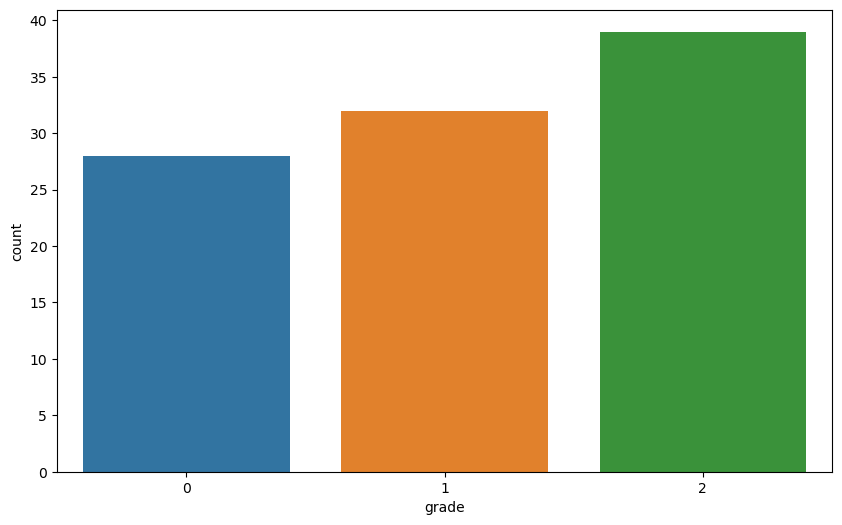

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.show()

*<h3>Data Cleaning<h3>*

In [8]:
df.drop('question_id', axis=1, inplace=True)

In [9]:
df.dropna(inplace=True)

In [10]:
df.drop_duplicates(inplace=True)
print(df['answer'])

0     في المدينة المنورة، 570 ميلادي: نبض الإسلام، و...
1     قريش، مكة: نبينا الكريم -صلى الله عليه وسلم-، ...
2     تاريخ مكة يتلألأ بميلاد المصطفى محمد -صلى الله...
3     قريش: جذور نبوية، مكة: مهد الإسلام، محمد -صلى ...
4     جذور قريش وأحضان مكة، شهدتا نور البعثة: مولد س...
                            ...                        
94    مكة المكرمة شهدت ولادة النبي -صلى الله عليه وس...
95    كعبة الله، قريش: أمانة الإسلام، محمد -صلى الله...
96        ولد رسول الله عليه الصَّلاة والسَّلام في يثرب
97    بلدة قريش العريقة، احتضنت أعظم ميلاد: محمد -صل...
98    رسول الله -صلى الله عليه وسلم- وُلِد في مكة ال...
Name: answer, Length: 99, dtype: object


*<h3>Data Pre-Preocessing<h3>*

In [11]:
le = LabelEncoder()
df['grade'] = le.fit_transform(df['grade'])

stanza.download('ar')
nlp = stanza.Pipeline('ar')

def preprocess_text(text):
    doc = nlp(text)
    tokens = [word.lemma for sent in doc.sentences for word in sent.words if word.upos != 'PUNCT']
    return tokens

df['answer'] = df['answer'].apply(preprocess_text)

2024-01-09 22:49:24 INFO: Downloading default packages for language: ar (Arabic) ...
2024-01-09 22:49:25 INFO: File exists: C:\Users\amine\stanza_resources\ar\default.zip
2024-01-09 22:49:30 INFO: Finished downloading models and saved to C:\Users\amine\stanza_resources.
2024-01-09 22:49:30 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-01-09 22:49:33 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-01-09 22:49:33 INFO: Using device: cpu
2024-01-09 22:49:33 INFO: Loading: tokenize
2024-01-09 22:49:34 INFO: Loading: mwt
2024-01-09 22:49:34 INFO: Loading: pos
2024-01-09 22:49:34 INFO: Loading: lemma
2024-01-09 22:49:34 INFO: Loading: depparse
2024-01-09 22:49:34 INFO: Loading: ner
2024-01-09 22:49:35 INFO: Done loading processors!


In [12]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['answer'])
sequences = tokenizer.texts_to_sequences(df['answer'])
max_sequence_length = max(len(s) for s in sequences)
sequences = pad_sequences(sequences,max_sequence_length)
word2idx = tokenizer.word_index
vocab_size = len(word2idx) + 1


X = pad_sequences(sequences, padding='post', truncating='post', maxlen=max_sequence_length)

print(sequences)
print(df['answer'])

Y = to_categorical(df['grade'], num_classes=3)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)


[[  0   0   0 ...   2   1   6]
 [  0   0   0 ...   6  22 115]
 [  0   0   0 ...  35  23  36]
 ...
 [  0   0   0 ...  15   7 199]
 [  0   0   0 ...   6  86  35]
 [  0   0   0 ...   7   8  18]]
0     [فِي, مَدِينَة, مُنَوَّر, 570, مِيلَادِي, نَبض...
1     [قريش, مكة, نبينا, الكريم, صَلَّى, الله, عَلَى...
2     [تَارِيخ, مَكَّة, تَلَأَّأ, بِ, مِيلَاد, المصط...
3     [قريش, جِذر, نَبَوِيّ, مَكَّة, مَهَّد, إِسلَام...
4     [جذور, قريش, وَ, حُضن, مكة, شَهِد, نور, بَعثَة...
                            ...                        
94    [مَكَّة, مُكَرَّم, شَهِد, وِلَادَة, نَبِيّ, صَ...
95    [كعبة, الله, قريش, أَمَانَة, إِسلَام, محمد, صَ...
96    [وَ, لَدّ, رَسُول, الله, عَلَى, هُوَ, صََرَاة,...
97    [بَلدَة, قريش, عَرِيق, اِحتَضَن, أَعظَم, مِيلَ...
98    [رَسُول, الله, صَلَّى, الله, عَلَى, هُوَ, وَ, ...
Name: answer, Length: 99, dtype: object


*<h3>build Models<h3>*

*<h4>RNN Model<h4>*

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, Y, test_size=0.2)

def RNN_model(vocab_size, sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length))
    model.add(SimpleRNN(units=128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(SimpleRNN(units=64, activation='sigmoid'))
    model.add(Dense(256, activation='sigmoid', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)
#EMBEDDING_DIM = 110
rnn_model = RNN_model(vocab_size, max_sequence_length)
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_updated_rnn = rnn_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=100, batch_size=64, callbacks=[reduce_lr])

# Evaluate the RNN model
evaluation_metrics_updated_rnn = rnn_model.evaluate(X_test, Y_test)
print("Evaluation Metrics for RNN:")
for metric_name, metric_value in zip(rnn_model.metrics_names, evaluation_metrics_updated_rnn):
    print(f"{metric_name}: {metric_value}")


Epoch 1/100


2/2 [==============================] - 5s 602ms/step - loss: 1.3001 - accuracy: 0.3038 - val_loss: 1.2063 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 54ms/step - loss: 1.1960 - accuracy: 0.3165 - val_loss: 1.2249 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 1.1445 - accuracy: 0.4688
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2/2 [==============================] - 0s 52ms/step - loss: 1.1422 - accuracy: 0.4684 - val_loss: 1.2144 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 52ms/step - loss: 1.1194 - accuracy: 0.4430 - val_loss: 1.2117 - val_accuracy: 0.4000 - lr: 2.0000e-04
Epoch 5/100
1/2 [==============>...............] - ETA: 0s - loss: 1.1961 - accuracy: 0.3594
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001.
2/2 [==============================] - 0s 73ms/step - loss: 1.1620 -

*<h4>LSTM Model<h4>*

In [14]:
def LSTM_model(vocab_size, sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length))
    model.add(LSTM(units=128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, activation='relu'))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


#EMBEDDING_DIM = 110
lstm_model = LSTM_model(vocab_size, max_sequence_length)
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_updated_rnn = lstm_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=100, batch_size=64, callbacks=[early_stopping_rnn])


# Evaluate the lstm model
evaluation_metrics_updated_lstm = lstm_model.evaluate(X_test, Y_test)
print("Evaluation Metrics for LSTM:")
for metric_name, metric_value in zip(lstm_model.metrics_names, evaluation_metrics_updated_lstm):
    print(f"{metric_name}: {metric_value}")

    

Epoch 1/100
2/2 [==============================] - 5s 633ms/step - loss: 1.1946 - accuracy: 0.3418 - val_loss: 1.1968 - val_accuracy: 0.4000
Epoch 2/100
2/2 [==============================] - 0s 69ms/step - loss: 1.1309 - accuracy: 0.4937 - val_loss: 1.1919 - val_accuracy: 0.4000
Epoch 3/100
2/2 [==============================] - 0s 69ms/step - loss: 1.0586 - accuracy: 0.5823 - val_loss: 1.1856 - val_accuracy: 0.4000
Epoch 4/100
2/2 [==============================] - 0s 97ms/step - loss: 0.9583 - accuracy: 0.7595 - val_loss: 1.1780 - val_accuracy: 0.4500
Epoch 5/100
2/2 [==============================] - 0s 84ms/step - loss: 0.8508 - accuracy: 0.7975 - val_loss: 1.1719 - val_accuracy: 0.7000
Epoch 6/100
2/2 [==============================] - 0s 102ms/step - loss: 0.7103 - accuracy: 0.8354 - val_loss: 1.1662 - val_accuracy: 0.6500
Epoch 7/100
2/2 [==============================] - 0s 83ms/step - loss: 0.5312 - accuracy: 0.8861 - val_loss: 1.1573 - val_accuracy: 0.3500
Epoch 8/100
2/2 [=

*<h4>TRANSFORMER Model<h4>*

In [15]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, density, rate=0.1, l2_reg=0.01):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(density, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def build_transformer_model(maxlen, vocab_size, embed_dim, num_heads, density, transformer_units, mlp_units, dropout_rate, num_classes):
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    for _ in range(transformer_units):
        x = TransformerBlock(embed_dim, num_heads, density, rate=dropout_rate)(x)
    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
maxlen = max_sequence_length
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 120
num_heads = 2
density = 3
transformer_units = 4
mlp_units = [128]
dropout_rate = 0.5
num_classes = len(df['grade'].unique())

transformer_model = build_transformer_model(maxlen, vocab_size, embed_dim, num_heads, density, transformer_units, mlp_units, dropout_rate, num_classes)


In [17]:
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))
history = transformer_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/30
3/3 [==============================] - 11s 573ms/step - loss: 1.7482 - accuracy: 0.2976 - val_loss: 1.9421 - val_accuracy: 0.0667
Epoch 2/30
3/3 [==============================] - 0s 69ms/step - loss: 1.6357 - accuracy: 0.3214 - val_loss: 1.4400 - val_accuracy: 0.4000
Epoch 3/30
3/3 [==============================] - 0s 69ms/step - loss: 1.4431 - accuracy: 0.5238 - val_loss: 1.5761 - val_accuracy: 0.3333
Epoch 4/30
3/3 [==============================] - 0s 65ms/step - loss: 1.3723 - accuracy: 0.5000 - val_loss: 1.2915 - val_accuracy: 0.6667
Epoch 5/30
3/3 [==============================] - 0s 68ms/step - loss: 1.2790 - accuracy: 0.5714 - val_loss: 1.0535 - val_accuracy: 0.8667
Epoch 6/30
3/3 [==============================] - 0s 63ms/step - loss: 1.1111 - accuracy: 0.6786 - val_loss: 1.2253 - val_accuracy: 0.7333
Epoch 7/30
3/3 [==============================] - 0s 62ms/step - loss: 1.0149 - accuracy: 0.6786 - val_loss: 0.9922 - val_accuracy: 0.8000
Epoch 8/30
3/3 [========

In [18]:
evaluation_metrics_transformer = transformer_model.evaluate(X_test, Y_test)
print("Evaluation Metrics Transformer:")
for metric_name, metric_value in zip(transformer_model.metrics_names, evaluation_metrics_transformer):
    print(f"{metric_name}: {metric_value}")


1/1 [==============================] - 0s 51ms/step - loss: 1.3428 - accuracy: 0.8000
Evaluation Metrics Transformer:
loss: 1.3427586555480957
accuracy: 0.800000011920929


In [19]:
evaluation_metrics_transformer = transformer_model.evaluate(X_test, Y_test)

predictions = transformer_model.predict(X_test)
print(X_test)

# Convert one-hot encoded labels to class indices
y_true = np.argmax(Y_test, axis=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(predictions, axis=1)

# Create DataFrame
results_df = pd.DataFrame({"Real": y_true, "Predicted": y_pred})

# Display DataFrame
print("\nReal and Predicted Values:")
print(results_df)


1/1 [==============================] - 1s 1s/step
[[  0   0   0   0   0   0   0   0   0 162 163  10  12   3   4   2  16   1
   15 164 165  28  10   2 166]
 [  0   0   0   0   0  83  17   2  63  11  18  33  45  10  27  25  23  97
   98   5   3   4   2   1   6]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 114   3  13  34  14
    9   5   3   4   2   1   6]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  61 127  34  14
   58   5   3   4   2   1   6]
 [  0   0   0   0   0   0   0   0   0   0 200  13  48  70 113  10   9   5
    3   4   2   1   6  86  35]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   9   5   3   4
    2   1   6  13  11  10  24]
 [  0   0   0   0   0   0   0   0   0   0   0   1  19  12   3   4   2  16
    1  15   7  28  59  89 170]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  99 153  28   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   28  10   2 120   7  80  24]
 [  0

In [20]:
# Evaluate RNN model
rnn_accuracy = rnn_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy RNN:", rnn_accuracy)

# Evaluate LSTM model
lstm_accuracy = lstm_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy LSTM:", lstm_accuracy)

# Evaluate Transformer model
transformer_accuracy = transformer_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy Transformer:", transformer_accuracy)



Accuracy RNN: 0.9333333373069763
Accuracy LSTM: 0.9333333373069763
Accuracy Transformer: 0.800000011920929


In [21]:
# Determine the best model
best_model_name, best_model_accuracy = max([('RNN', rnn_accuracy), ('LSTM', lstm_accuracy), ('Transformer', transformer_accuracy)], key=lambda x: x[1])

save_path = './savedModels/q4_model.h5'
# Save the best model
if best_model_name == 'RNN':
    rnn_model.save(save_path)
elif best_model_name == 'LSTM':
    lstm_model.save(save_path)
elif best_model_name == 'Transformer':
    transformer_model.save(save_path)

print(f"The best model ({best_model_name}) with accuracy {best_model_accuracy} has been saved to '{save_path}'")


The best model (RNN) with accuracy 0.9333333373069763 has been saved to './savedModels/q4_model.h5'
